# Python: Causal Machine Learning with TabPFN

In this example, we demonstrate how to use [TabPFN](https://github.com/automl/TabPFN) (Tabular Prior-data Fitted Network) as a machine learning estimator within the [DoubleML](https://docs.doubleml.org/stable/index.html) framework for causal inference. We compare TabPFN's performance against (untuned) traditional machine learning methods including Random Forest, Linear models, and LightGBM.

TabPFN is a foundation model specifically designed for tabular data that can perform inference without traditional training. It leverages a transformer architecture trained on a vast collection of synthetic tabular datasets, making it particularly effective for small to medium-sized datasets commonly encountered in causal inference applications.

We will estimate **Average Potential Outcomes (APOs)** using the [DoubleMLAPOS](https://docs.doubleml.org/stable/api/generated/doubleml.irm.DoubleMLAPOS.html) model, which allows us to estimate:

$$\theta_d = \mathbb{E}[Y(d)]$$

for different treatment levels $d$ in a discrete treatment setting.

## Imports and Setup

We start by importing the necessary libraries. Note that TabPFN requires a separate installation, see [installation instructions](https://priorlabs.ai/getting_started/install/).

For GPU acceleration (recommended), ensure you have CUDA-enabled PyTorch installed.
Instead you can also use the [TabPFN API Client](https://github.com/PriorLabs/tabpfn-client).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import lightgbm as lgbm
from tabpfn import TabPFNRegressor, TabPFNClassifier

import doubleml as dml
from doubleml.datasets import make_irm_data_discrete_treatments

import warnings
warnings.filterwarnings("ignore", message="Running on CPU*", category=UserWarning, module="tabpfn")
warnings.filterwarnings("ignore", message=".*does not have valid feature names.*", category=UserWarning, module="lgbm")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

## Data Generating Process (DGP)

We generate synthetic data using DoubleML's discrete treatment data generating process. This creates:
- A continuous treatment variable that is subsequently discretized into multiple levels $D$
- True individual treatment effects (ITEs) for comparison with our estimates
- Covariates $X$ that affect both treatment assignment $D$ and outcomes $Y$

The discretization allows us to compare estimated Average Potential Outcomes (APOs) and Average Treatment Effects (ATEs) against their true values, providing a clear benchmark for evaluating different machine learning methods.
For more details on the data generating process and the APO model, we refer to the [APO Model Example Notebook](https://docs.doubleml.org/stable/examples/py_double_ml_apo.html).

In [2]:
# Parameters
n_obs = 1000
n_levels = 5
linear = False
n_rep = 1

np.random.seed(42)
data_apo = make_irm_data_discrete_treatments(n_obs=n_obs,n_levels=n_levels, linear=linear)

y0 = data_apo['oracle_values']['y0']
cont_d = data_apo['oracle_values']['cont_d']
ite = data_apo['oracle_values']['ite']
d = data_apo['d']
potential_level = data_apo['oracle_values']['potential_level']
level_bounds = data_apo['oracle_values']['level_bounds']

average_ites = np.full(n_levels + 1, np.nan)
apos = np.full(n_levels + 1, np.nan)
mid_points = np.full(n_levels, np.nan)

for i in range(n_levels + 1):
    average_ites[i] = np.mean(ite[d == i]) * (i > 0)
    apos[i] = np.mean(y0) + average_ites[i]

print(f"Average treatment effects in each group:\n{np.round(average_ites,2)}\n")
print(f"Average potential outcomes in each group:\n{np.round(apos,2)}\n")
print(f"Levels and their counts:\n{np.unique(d, return_counts=True)}")

Average treatment effects in each group:
[ 0.    1.46  6.67  9.31 10.36 10.47]

Average potential outcomes in each group:
[209.9  211.36 216.56 219.2  220.26 220.37]

Levels and their counts:
(array([0., 1., 2., 3., 4., 5.]), array([183, 165, 154, 162, 175, 161]))


### Visualizing the Treatment Effect Structure

To better understand our data, let's visualize the relationship between the continuous treatment variable and the individual treatment effects, along with how the treatment is discretized into levels.

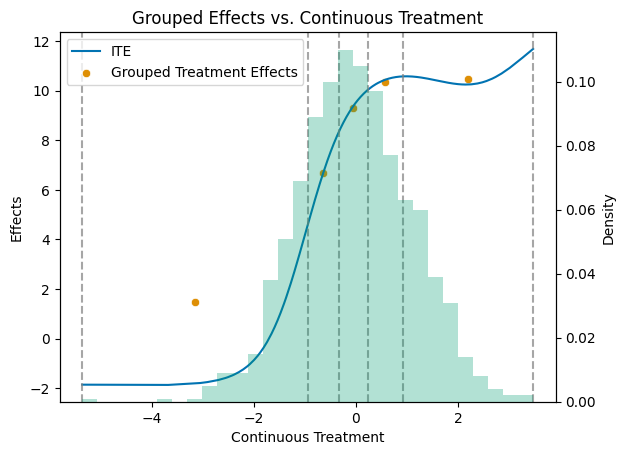

In [3]:
# Get a colorblind-friendly palette
palette = sns.color_palette("colorblind")

df = pd.DataFrame({'cont_d': cont_d, 'ite': ite})
df_sorted = df.sort_values('cont_d')

mid_points = np.full(n_levels, np.nan)
for i in range(n_levels):
    mid_points[i] = (level_bounds[i] + level_bounds[i + 1]) / 2

df_apos = pd.DataFrame({'mid_points': mid_points, 'treatment effects': apos[1:] - apos[0]})

# Create the primary plot with scatter and line plots
fig, ax1 = plt.subplots()

sns.lineplot(data=df_sorted, x='cont_d', y='ite', color=palette[0], label='ITE', ax=ax1)
sns.scatterplot(data=df_apos, x='mid_points', y='treatment effects', color=palette[1], label='Grouped Treatment Effects', ax=ax1)

# Add vertical dashed lines at level_bounds
for bound in level_bounds:
    ax1.axvline(x=bound, color='grey', linestyle='--', alpha=0.7)

ax1.set_title('Grouped Effects vs. Continuous Treatment')
ax1.set_xlabel('Continuous Treatment')
ax1.set_ylabel('Effects')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot the histogram on the secondary y-axis
ax2.hist(df_sorted['cont_d'], bins=30, alpha=0.3, weights=np.ones_like(df_sorted['cont_d']) / len(df_sorted['cont_d']), color=palette[2])
ax2.set_ylabel('Density')

# Make sure the legend includes all plots
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

plt.show()

### Creating the DoubleMLData Object

As with all DoubleML models, we need to create a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.data.DoubleMLData.html) object to properly structure our data for causal inference. This object handles the separation of outcome variables, treatment variables, and covariates.

In [4]:
y = data_apo['y']
x = data_apo['x']
d = data_apo['d']
df_apo = pd.DataFrame(
    np.column_stack((y, d, x)),
    columns=['y', 'd'] + ['x' + str(i) for i in range(data_apo['x'].shape[1])]
)

dml_data = dml.DoubleMLData(df_apo, 'y', 'd')
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['x0', 'x1', 'x2', 'x3', 'x4']
Instrument variable(s): None
No. Observations: 1000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 7 entries, y to x4
dtypes: float64(7)
memory usage: 54.8 KB



## DoubleML with TabPFN

The [TabPFN package](https://github.com/PriorLabs/tabpfn) integrates seamlessly with the [DoubleML](https://docs.doubleml.org/stable/index.html) framework for causal inference tasks.

For fitting [average potential outcome models](https://docs.doubleml.org/stable/guide/models.html#average-potential-outcomes-apos), the `DoubleML` interface requires to specify the `ml_g` and `ml_m` learners:
- `ml_g`: A regressor for the outcome model $g_0(D,X) = \mathbb{E}[Y|X,D]$
- `ml_m`: A classifier for the propensity score model $m_{0,d}(X) = \mathbb{E}[1\{D=d\}|X]$

**Note**: TabPFN works best with CUDA acceleration. If CUDA is not available, it will fall back to CPU computation. Instead you can use [TabPFN API Client](https://github.com/PriorLabs/tabpfn-client).

In [5]:
device = 'cpu'
ml_g = TabPFNRegressor(device=device)
ml_m = TabPFNClassifier(device=device)

To model average potential outcomes, we initialize the [DoubleMLAPOS](https://docs.doubleml.org/stable/api/generated/doubleml.irm.DoubleMLAPOS.html#doubleml.irm.DoubleMLAPOS) object with the specified machine learning methods and treatment levels.

In [6]:
treatment_levels = np.unique(dml_data.d)
dml_obj = dml.DoubleMLAPOS(
    dml_data,
    ml_g=ml_g,
    ml_m=ml_m,
    treatment_levels=treatment_levels,
    n_rep=n_rep,
)

As usual, you can estimate the parameters by calling the `fit` method on the `dml_obj` instance.

In [7]:
dml_obj.fit()
print(dml_obj)

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

================== DoubleMLAPOS Object ==================

------------------ Fit summary       ------------------
           coef   std err           t  P>|t|       2.5 %      97.5 %
0.0  209.395480  1.211939  172.777199    0.0  207.020123  211.770838
1.0  210.966031  1.367425  154.279824    0.0  208.285928  213.646134
2.0  216.538410  1.245027  173.922656    0.0  214.098202  218.978618
3.0  219.333914  1.334717  164.329850    0.0  216.717916  221.949912
4.0  219.905724  1.278724  171.972735    0.0  217.399470  222.411977
5.0  219.265669  1.177094  186.277179    0.0  216.958608  221.572730


## Machine Learning Methods Comparison

We compare four different machine learning approaches for estimating the nuisance functions in our causal model:

1. **Random Forest**: Ensemble method with bagging and random feature selection
2. **Linear Models**: Linear/Logistic regression
3. **LightGBM**: Gradient boosting framework
4. **TabPFN**: A foundation model for tabular data

In [8]:
learner_dict = {
    'RandomForest': {
        'ml_g': RandomForestRegressor(),
        'ml_m': RandomForestClassifier()
    },
    'Linear': {
        'ml_g': LinearRegression(),
        'ml_m': LogisticRegression(max_iter=1000)
    },
    'LightGBM': {
        'ml_g': lgbm.LGBMRegressor(n_estimators=50, verbose=-1),
        'ml_m': lgbm.LGBMClassifier(n_estimators=50, verbose=-1)
    },
    'TabPFN': {
        'ml_g': TabPFNRegressor(device=device),
        'ml_m': TabPFNClassifier(device=device)
    }
}

### Estimation of Average Potential Outcomes

Now we estimate the Average Potential Outcomes (APOs) for each treatment level using all four machine learning methods. We use the [DoubleMLAPOS](https://docs.doubleml.org/dev/api/generated/doubleml.irm.DoubleMLAPOS.html) class, which:

1. **Estimates nuisance functions**: Uses cross-fitting to estimate $g_0(D,X)$ and $m_{0,d}(X)$ 
2. **Computes APO estimates**: Uses the efficient influence function to estimate $\theta_d = \mathbb{E}[Y(d)]$
3. **Provides confidence intervals**: Based on the asymptotic distribution of the estimator

We also compute **causal contrasts** (Average Treatment Effects) as differences between treatment levels and the reference level (no treatment).

In [9]:
reference_level = 0 

apo_results = []
causal_contrast_results = []
model_list = []

for learner_name, learner_pair in learner_dict.items():
    # Recreate dml_obj for each learner (as in the main loop)
    dml_obj = dml.DoubleMLAPOS(
        dml_data,
        learner_pair['ml_g'],
        learner_pair['ml_m'],
        treatment_levels=treatment_levels,
        n_rep=n_rep,
    )
    dml_obj.fit()
    model_list.append(dml_obj)

    # APO confidence intervals
    ci_pointwise = dml_obj.confint(level=0.95)
    df_apos = pd.DataFrame({
        'learner': learner_name,
        'treatment_level': treatment_levels,
        'apo': dml_obj.coef,
        'ci_lower': ci_pointwise.values[:, 0],
        'ci_upper': ci_pointwise.values[:, 1]}
    )
    apo_results.append(df_apos)

    # ATE confidence intervals
    causal_contrast_model = dml_obj.causal_contrast(reference_levels=reference_level)
    ates = causal_contrast_model.thetas
    ci_ates = causal_contrast_model.confint(level=0.95)
    df_ates = pd.DataFrame({
        'learner': learner_name,
        'treatment_level': treatment_levels[1:],
        'ate': ates,
        'ci_lower': ci_ates.iloc[:, 0].values,
        'ci_upper': ci_ates.iloc[:, 1].values
    })
    causal_contrast_results.append(df_ates)

# Combine all results
df_all_apos = pd.concat(apo_results, ignore_index=True)
df_all_ates = pd.concat(causal_contrast_results, ignore_index=True)
df_all_ates

c:\Users\BAM5698\AppData\Local\miniconda3\envs\dml_docs\Lib\site-packages\doubleml\double_ml.py:1479: UserWarning: The estimated nu2 for d is not positive. Re-estimation based on riesz representer (non-orthogonal).
  warnings.warn(msg, UserWarning)
c:\Users\BAM5698\AppData\Local\miniconda3\envs\dml_docs\Lib\site-packages\doubleml\utils\_checks.py:194: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(
c:\Users\BAM5698\AppData\Local\miniconda3\envs\dml_docs\Lib\site-packages\doubleml\double_ml.py:1479: UserWarning: The estimated nu2 for d is not positive. Re-estimation based on riesz representer (non-orthogonal).
  warnings.warn(msg, UserWarning)
c:\Users\BAM5698\AppData\Local\miniconda3\envs\dml_docs\Lib\site-packages\doubleml\utils\_checks.py:194: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(
c:\Users\BAM5698

,learner,treatment_level,ate,ci_lower,ci_upper
0,RandomForest,1.0,1.325370,-4.218919,6.869658
1,RandomForest,2.0,5.702248,1.094595,10.309901
2,RandomForest,3.0,8.743203,4.080729,13.405677
3,RandomForest,4.0,6.632407,1.979031,11.285783
4,RandomForest,5.0,7.967206,2.359083,13.575329
5,Linear,1.0,4.971059,-1.231281,11.173400
6,Linear,2.0,7.963367,2.882965,13.043769
7,Linear,3.0,10.747538,6.745536,14.749540
8,Linear,4.0,11.594317,7.889236,15.299398
9,Linear,5.0,6.626998,3.014525,10.239471


### Visualizing Average Potential Outcomes

Let's compare the estimated APOs across all methods with their true values. The plot shows:
- **Estimated APOs**: Point estimates with 95% confidence intervals for each method
- **True APOs**: Red horizontal lines showing the oracle values
- **Treatment levels**: Different dosage levels of the treatment (0 = no treatment)

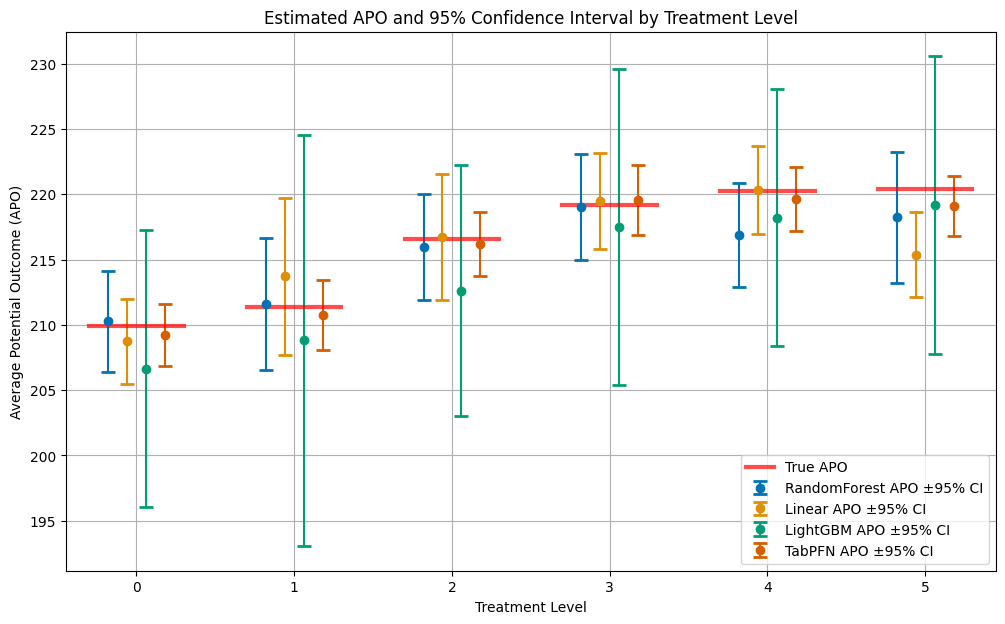

In [10]:
# Plot APOs and 95% CIs for all models
plt.figure(figsize=(12, 7))
palette = sns.color_palette("colorblind")
learners = df_all_apos['learner'].unique()
n_learners = len(learners)
jitter_strength = 0.12

for i, learner in enumerate(learners):
    df = df_all_apos[df_all_apos['learner'] == learner]
    # Jitter x positions for each learner
    jitter = (i - (n_learners - 1) / 2) * jitter_strength
    x_jittered = df['treatment_level'] + jitter
    plt.errorbar(
        x_jittered,
        df['apo'],
        yerr=[df['apo'] - df['ci_lower'], df['ci_upper'] - df['apo']],
        fmt='o',
        capsize=5,
        capthick=2,
        ecolor=palette[i % len(palette)],
        color=palette[i % len(palette)],
        label=f"{learner} APO ±95% CI",
        zorder=2
    )

# Get treatment levels for proper line positioning
treatment_levels = sorted(df_all_apos['treatment_level'].unique())
x_range = plt.xlim()
total_width = x_range[1] - x_range[0]

# Add true APOs as red horizontal lines
for i, level in enumerate(treatment_levels):
    # Center each line around its treatment level with a reasonable width
    line_width = 0.6  # Width of each horizontal line relative to treatment level spacing
    x_center = level
    x_start = x_center - line_width/2
    x_end = x_center + line_width/2
    
    # Convert to relative coordinates (0-1) for xmin/xmax
    xmin_rel = max(0, (x_start - x_range[0]) / total_width)
    xmax_rel = min(1, (x_end - x_range[0]) / total_width)
    
    plt.axhline(y=apos[int(level)], color='red', linestyle='-', alpha=0.7, 
                xmin=xmin_rel, xmax=xmax_rel,
                linewidth=3, label='True APO' if i == 0 else "")

plt.title('Estimated APO and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Average Potential Outcome (APO)')
plt.xticks(sorted(df_all_apos['treatment_level'].unique()))
plt.legend()
plt.grid(True)
plt.show()

It is quite clear to see, that without tuning the hyperparameters of the models, the TabPFN model achieves the best performance (smallest confidence intervals) across all treatment levels.

### Visualizing Average Treatment Effects

Now let's examine the Average Treatment Effects (ATEs), which represent the causal effect of each treatment level compared to the reference level (no treatment). The ATE for treatment level $d$ is defined as:

$$\text{ATE}_d = \mathbb{E}[Y(d)] - \mathbb{E}[Y(0)]$$

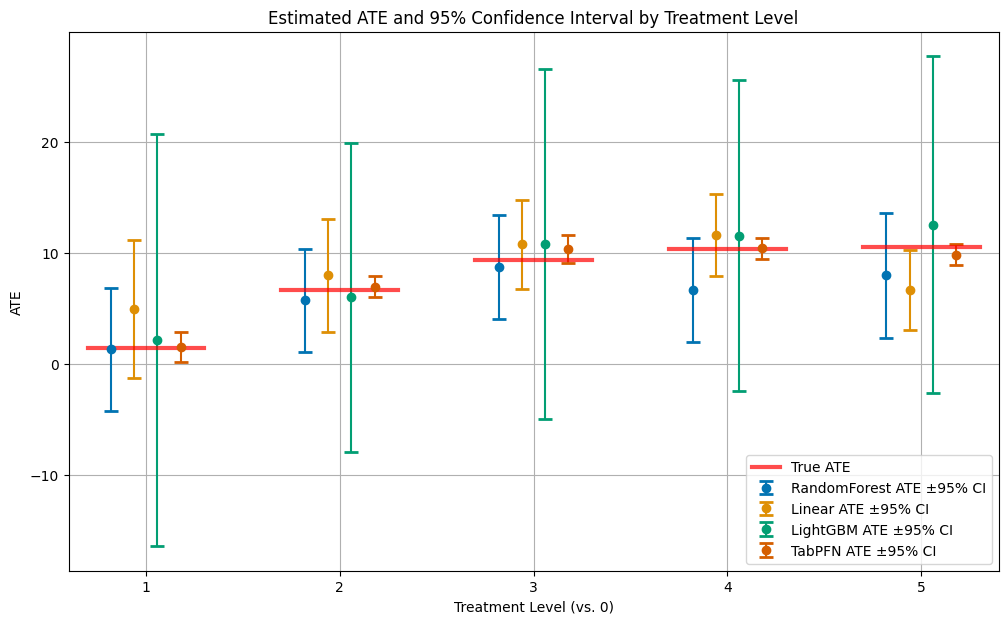

In [11]:
# Plot ATEs and 95% CIs for all models
plt.figure(figsize=(12, 7))
palette = sns.color_palette("colorblind")
learners = df_all_ates['learner'].unique()
n_learners = len(learners)
jitter_strength = 0.12

for i, learner in enumerate(learners):
    df = df_all_ates[df_all_ates['learner'] == learner]
    # Jitter x positions for each learner
    jitter = (i - (n_learners - 1) / 2) * jitter_strength
    x_jittered = df['treatment_level'] + jitter
    plt.errorbar(
        x_jittered,
        df['ate'],
        yerr=[df['ate'] - df['ci_lower'], df['ci_upper'] - df['ate']],
        fmt='o',
        capsize=5,
        capthick=2,
        ecolor=palette[i % len(palette)],
        color=palette[i % len(palette)],
        label=f"{learner} ATE ±95% CI",
        zorder=2
    )

# Get treatment levels for proper line positioning
treatment_levels = sorted(df_all_ates['treatment_level'].unique())
x_range = plt.xlim()
total_width = x_range[1] - x_range[0]

# Add true ATEs as red horizontal lines
for i, level in enumerate(treatment_levels):
    # Center each line around its treatment level with a reasonable width
    line_width = 0.6  # Width of each horizontal line relative to treatment level spacing
    x_center = level
    x_start = x_center - line_width/2
    x_end = x_center + line_width/2
    
    # Convert to relative coordinates (0-1) for xmin/xmax
    xmin_rel = max(0, (x_start - x_range[0]) / total_width)
    xmax_rel = min(1, (x_end - x_range[0]) / total_width)
    
    # Use average_ites[level] for the true ATE (treatment levels start from 1 for ATEs)
    plt.axhline(y=average_ites[int(level)], color='red', linestyle='-', alpha=0.7, 
                xmin=xmin_rel, xmax=xmax_rel,
                linewidth=3, label='True ATE' if i == 0 else "")

plt.title('Estimated ATE and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level (vs. 0)')
plt.ylabel('ATE')
plt.xticks(sorted(df_all_ates['treatment_level'].unique()))
plt.legend()
plt.grid(True)
plt.show()

### Model Performance Evaluation

To understand why different methods perform differently, let's examine the performance of the underlying machine learning models used for the nuisance functions. DoubleML provides access to performance metrics for each component:

- **RMSE g0**: Root Mean Square Error for the outcome model when treatment $D \neq d$
- **RMSE g1**: Root Mean Square Error for the outcome model when treatment $D = d$
- **LogLoss m**: Logarithmic loss for the propensity score model (treatment assignment prediction)

Better performance on these nuisance functions typically translates to more accurate causal estimates.

In [12]:
# Create a comprehensive table with RMSE for g0, g1 and log loss for all learners and treatment levels
performance_results = []

for idx_learner, learner_name in enumerate(learner_dict.keys()):
    for idx_treat, treatment_level in enumerate(treatment_levels):
        # Get the specific model for this learner and treatment level
        model = model_list[idx_learner].modellist[idx_treat]
        
        # Extract performance metrics from nuisance_loss
        if model.nuisance_loss is not None:
            # RMSE for g0 (outcome model for treatment level != d)
            rmse_g0 = model.nuisance_loss['ml_g_d_lvl0'][0][0]
            
            # RMSE for g1 (outcome model for treatment level = d)
            rmse_g1 = model.nuisance_loss['ml_g_d_lvl1'][0][0]
            
            # Log loss for propensity score model
            logloss_m = model.nuisance_loss['ml_m'][0][0]
        else:
            rmse_g0 = rmse_g1 = logloss_m = None
        
        # Store results
        performance_results.append({
            'Learner': learner_name,
            'Treatment_Level': treatment_level,
            'RMSE_g0': rmse_g0,
            'RMSE_g1': rmse_g1,
            'LogLoss_m': logloss_m
        })

# Create DataFrame and display as a nicely formatted table
df_performance = pd.DataFrame(performance_results)

# Round values for better readability
df_performance['RMSE_g0'] = df_performance['RMSE_g0'].round(4)
df_performance['RMSE_g1'] = df_performance['RMSE_g1'].round(4)
df_performance['LogLoss_m'] = df_performance['LogLoss_m'].round(4)

print("\n\nRMSE g0 by Learner and Treatment Level:")
print("=" * 80)
pivot_rmse_g0 = df_performance.pivot(index='Learner', columns='Treatment_Level', values='RMSE_g0')
print(pivot_rmse_g0.to_string())

print("\n\nRMSE g1 by Learner and Treatment Level:")
print("=" * 80)
pivot_rmse_g1 = df_performance.pivot(index='Learner', columns='Treatment_Level', values='RMSE_g1')
print(pivot_rmse_g1.to_string())

print("\n\nLogLoss m by Learner and Treatment Level:")
print("=" * 80)
pivot_logloss = df_performance.pivot(index='Learner', columns='Treatment_Level', values='LogLoss_m')
print(pivot_logloss.to_string())



RMSE g0 by Learner and Treatment Level:
Treatment_Level      1.0      2.0      3.0      4.0      5.0
Learner                                                     
LightGBM         15.2287  11.1751  15.2422  15.1509  14.8526
Linear           21.1795  17.4716  20.3264  20.9783  21.0718
RandomForest     14.3663  11.4107  14.5979  14.5166  14.3334
TabPFN           10.0373   2.8767  10.5702   9.9764  10.2091


RMSE g1 by Learner and Treatment Level:
Treatment_Level      1.0      2.0      3.0      4.0      5.0
Learner                                                     
LightGBM         17.2116  31.2223  20.1003  18.2962  15.7370
Linear           16.6144  30.1755  21.2086  18.4788  16.9636
RandomForest     16.0477  25.8403  18.6678  19.0762  15.5213
TabPFN            3.3852  16.5840   4.8130   6.5550   4.9701


LogLoss m by Learner and Treatment Level:
Treatment_Level     1.0     2.0     3.0     4.0     5.0
Learner                                                
LightGBM         0.5732  0.5

### Performance Summary and Insights

Let's summarize the average performance across all treatment levels to identify the best-performing methods:

In [13]:
# Best performing learners for each metric
print("\nBest performing learners (averaged across treatment levels):")
print("-" * 60)

# Calculate average metrics across treatment levels for each learner
summary_stats = df_performance.groupby('Learner')[['RMSE_g0', 'RMSE_g1', 'LogLoss_m']].mean().round(4)
print(summary_stats)


Best performing learners (averaged across treatment levels):
------------------------------------------------------------
              RMSE_g0  RMSE_g1  LogLoss_m
Learner                                  
LightGBM      14.3299  20.5135     0.5424
Linear        20.2055  20.6882     0.4509
RandomForest  13.8450  19.0307     0.4849
TabPFN         8.7339   7.2615     0.4510


## Key Takeaways

This example demonstrates several important findings about using TabPFN for causal inference.

- **Outcome modeling**: TabPFN significantly outperforms traditional methods for both g0 and g1 functions, with much lower RMSE values
- **Causal estimates**: The superior nuisance function performance translates to more accurate APO and ATE estimates
- **No hyperparameter tuning**: TabPFN achieves these results without any model-specific tuning
